<a href="https://colab.research.google.com/github/bhadreshpsavani/EfficientQAExperiments/blob/master/text_summary_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

## Imports

In [78]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from keras.layers import Embedding, LSTM, Dense, TimeDistributed, Input
from keras.models import Model
from keras.callbacks import EarlyStopping

import tensorflow as tf
import time
from os import listdir
import string
from pickle import dump,load
import pickle
from keras.callbacks import ModelCheckpoint
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir("/content/drive/MyDrive/cnn_dailymail")

Mounted at /content/drive


## Load the Data

In [2]:
import pandas as pd

summary = pd.read_csv('/content/news_summary.csv',
                      encoding='iso-8859-1')
raw = pd.read_csv('/content/news_summary_more.csv',
                  encoding='iso-8859-1')

pre1 = raw.iloc[:, 0:2].copy()
pre2 = summary.iloc[:, 0:6].copy()

# To increase the intake of possible text values to build a reliable model
pre2['text'] = pre2['author'].str.cat(pre2['date'
        ].str.cat(pre2['read_more'].str.cat(pre2['text'
        ].str.cat(pre2['ctext'], sep=' '), sep=' '), sep=' '), sep=' ')

data = pd.DataFrame()
data['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
data['summary'] = pd.concat([pre1['headlines'], pre2['headlines']],
                           ignore_index=True)

In [4]:
summary.to_csv("news_summary.csv", index=False)
raw.to_csv("news_summary_more.csv", index=False)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102915 entries, 0 to 102914
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     102797 non-null  object
 1   summary  102915 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


## Step 2: Cleaning the Data

In [6]:
import re

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(column):
  for row in column:
    row = re.sub("(\\t)", " ", str(row)).lower()
    row = re.sub("(\\r)", " ", str(row)).lower()
    row = re.sub("(\\n)", " ", str(row)).lower()

    # Remove _ if it occurs more than one time consecutively
    row = re.sub("(__+)", " ", str(row)).lower()

    # Remove - if it occurs more than one time consecutively
    row = re.sub("(--+)", " ", str(row)).lower()

    # Remove ~ if it occurs more than one time consecutively
    row = re.sub("(~~+)", " ", str(row)).lower()

    # Remove + if it occurs more than one time consecutively
    row = re.sub("(\+\++)", " ", str(row)).lower()

    # Remove . if it occurs more than one time consecutively
    row = re.sub("(\.\.+)", " ", str(row)).lower()

    # Remove the characters - <>()|&©ø"',;?~*!
    row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

    # Remove mailto:
    row = re.sub("(mailto:)", " ", str(row)).lower()

    # Remove \x9* in text
    row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

    # Replace INC nums to INC_NUM
    row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

    # Replace CM# and CHG# to CM_NUM
    row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

    # Remove punctuations at the end of a word
    row = re.sub("(\.\s+)", " ", str(row)).lower()
    row = re.sub("(\-\s+)", " ", str(row)).lower()
    row = re.sub("(\:\s+)", " ", str(row)).lower()

    # Replace any url to only the domain name
    try:
        url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
        repl_url = url.group(3)
        row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
    except:
        pass

    # Remove multiple spaces
    row = re.sub("(\s+)", " ", str(row)).lower()

    # Remove the single character hanging between any two spaces
    row = re.sub("(\s+.\s+)", " ", str(row)).lower()

    yield row

In [7]:
import spacy
from time import time

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

In [10]:
# Process text as batches and yield Doc objects in order
from tqdm import tqdm
processed_text = text_strip(data['text'])
text = [str(doc) for doc in tqdm(nlp.pipe(processed_text, batch_size=100))]

102915it [08:12, 208.77it/s]


In [11]:
processed_summary = text_strip(data['summary'])
summary = ['_START_ '+ str(doc) + ' _END_' for doc in tqdm(nlp.pipe(processed_summary, batch_size=1000))]

102915it [01:18, 1308.38it/s]


In [12]:
text[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [13]:
summary[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

## Step 3: Determining the Maximum Permissible Sequence Lengths

In [14]:
data['cleaned_text'] = pd.Series(text)
data['cleaned_summary'] = pd.Series(summary)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102915 entries, 0 to 102914
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             102797 non-null  object
 1   summary          102915 non-null  object
 2   cleaned_text     102915 non-null  object
 3   cleaned_summary  102915 non-null  object
dtypes: object(4)
memory usage: 3.1+ MB


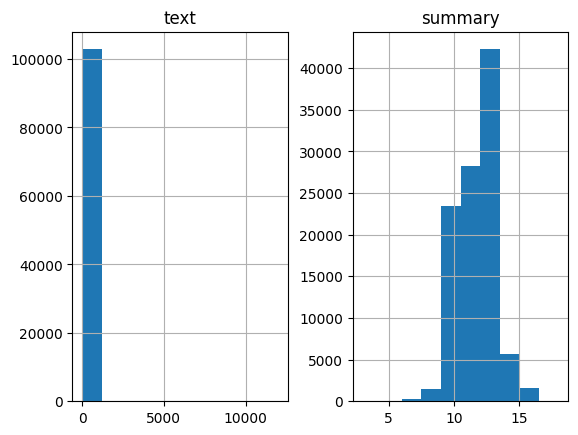

In [16]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in data['cleaned_text']:
    text_count.append(len(sent.split()))

for sent in data['cleaned_summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame()

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 10)
plt.show()

In [28]:
# Check how much % of text have 0-100 words
cnt = 0
for i in data['cleaned_text']:
    if len(i.split()) <= 100:
        cnt = cnt + 1
print(cnt / len(data['cleaned_text']))

0.9578389933440218


In [29]:
# Check how much % of text have 0-20 words
cnt = 0
for i in data['cleaned_summary']:
    if len(i.split()) <= 15:
        cnt = cnt + 1
print(cnt / len(data['cleaned_summary']))

0.9977748627508137


In [30]:
# Model to summarize the text between 0-15 words for Summary and 0-250 words for Text
max_text_len = 250
max_summary_len = 15

## Step 4: Selecting Plausible Texts and Summaries

In [31]:
# Select the Summaries and Text which fall below max length

import numpy as np

cleaned_text = np.array(data['cleaned_text'])
cleaned_summary= np.array(data['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})

post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...


In [32]:
post_pre.sample(5)

,text,summary
54334,aiadmk rajya sabha mp navaneethakrishnan on th...,_START_ delhi polluted move parliament session...
74983,chinese internet major baidu coo and ex-micros...,_START_ amazon ahead of microsoft google in ai...
3043,the kerala government has decided to bring an ...,_START_ kerala to bring law against damage of ...
59217,to keep elephants off railway tracks the north...,_START_ bee sounds used to keep elephants off ...
4841,markets regulator sebi imposed total penalty o...,_START_ sebi imposes ã¢ââ¹20 lakh fine on fir...


In [33]:
# Add sostok and eostok

post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x \
        + ' eostok')

post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...


## Step 5: Tokenizing the Text

In [34]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_pre["text"]),
    np.array(post_pre["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [35]:
# Tokenize the text to get the vocab count
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [36]:
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1

print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  62.72135239672281


In [37]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt)
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 30168


In [38]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1

print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 62.468528432933
Size of vocabulary in Y = 12970


## Step 6: Removing Empty Texts and Summaries

In [39]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens

ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [40]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

## Step 7: Creating the Model

In [41]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 250, 200)             6033600   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 250, 300),           601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

## Step 8: Training the Model

In [48]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=200,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/50


In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index


## Step 9: Generating Predictions

In [ ]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [ ]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [ ]:
for i in range(0, 19):
    print('Review:', seq2text(x_tr[i]))
    print('Original summary:', seq2summary(y_tr[i]))
    print('Predicted summary:', decode_sequence(x_tr[i].reshape(1,
           max_text_len)))
    print('\n')